SHAP library imported.
Libraries Imported Successfully.
Successfully loaded application_train_FinalEDA.csv

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   CNT_CHILDREN                 307511 non-null  float64
 2   AMT_INCOME_TOTAL             307511 non-null  float64
 3   AMT_CREDIT                   307511 non-null  float64
 4   AMT_ANNUITY                  307511 non-null  float64
 5   REGION_POPULATION_RELATIVE   307511 non-null  float64
 6   DAYS_BIRTH                   307511 non-null  float64
 7   DAYS_EMPLOYED                307511 non-null  float64
 8   DAYS_REGISTRATION            307511 non-null  float64
 9   OWN_CAR_AGE                  307511 non-null  float64
 10  REGION_RATING_CLIENT         307511 non-null  f

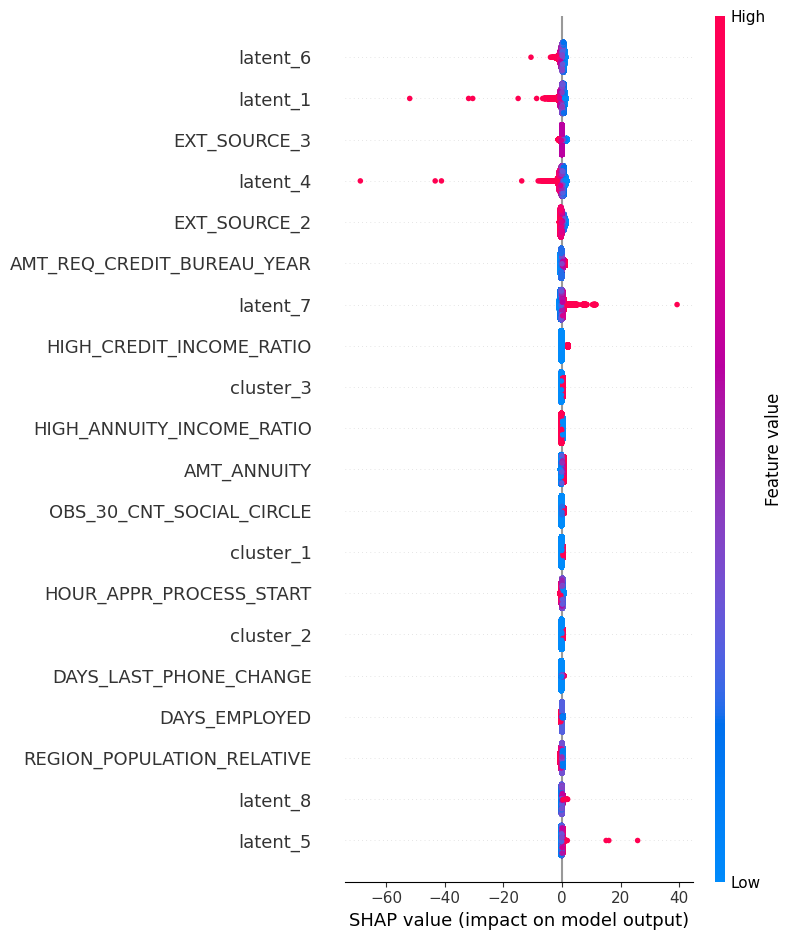


--- Anomaly Detection Plot ---


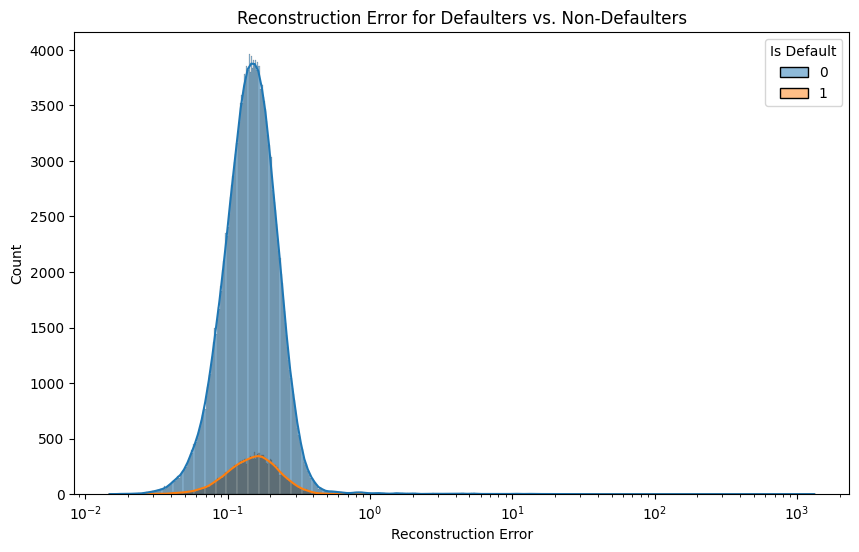


--- Project Complete ---


In [6]:
################################################################################
# STEP 1: IMPORTS & SETUP
################################################################################
import pandas as pd
import numpy as np
import shap
print("SHAP library imported.")

# Preprocessing & Clustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # <-- Added for NaN handling
from sklearn.cluster import KMeans

# Autoencoder Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError

# Hybrid Model (Supervised)
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from scipy.stats import ks_2samp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries Imported Successfully.")


################################################################################
# STEP 2: LOAD & PREPARE DATA (Using your 'application_train_FinalEDA' dataset)
################################################################################

# --- 1. LOAD YOUR FILE ---
file_name = 'application_train_FinalEDA.csv'  # Your dataset name
try:
    X_df = pd.read_csv(file_name)
    print(f"Successfully loaded {file_name}")
except FileNotFoundError:
    print(f"ERROR: Could not find the file named {file_name}.")
    print("Please upload your file to Colab and try again.")
    # Stop execution if file isn't loaded
    raise

# --- 2. IDENTIFY YOUR TARGET (y) AND FEATURES (X) ---
print("\n--- Dataset Info ---")
X_df.info()

# Change this to the *actual* name of your default/non-default column
target_column_name = 'TARGET'  # <-- EDIT THIS LINE IF 'TARGET' IS NOT CORRECT

# Check if the target column exists
if target_column_name not in X_df.columns:
    print(f"\n\nERROR: The column '{target_column_name}' was not found in your data.")
    print("Please update the 'target_column_name' variable to match your dataset.")
    raise ValueError("Target column not found")

# Separate the target (y) from the features (X)
y = X_df[target_column_name]
X_df = X_df.drop(columns=[target_column_name])

# --- 3. GET FEATURE NAMES ---
# This automatically gets all your feature names for the final report
feature_names = X_df.columns.tolist()

print(f"\nSetup complete.")
print(f"Target (y) variable: '{target_column_name}'")
print(f"Features (X) shape: {X_df.shape}")

# --- 4. HANDLE NON-NUMERIC COLUMNS (if any) ---
# Autoencoders and LogReg require all data to be numeric.
# We will use one-hot encoding for any 'object' type columns.

# Get list of non-numeric (object) columns
object_cols = X_df.select_dtypes(include='object').columns

if not object_cols.empty:
    print(f"\nFound object columns: {list(object_cols)}")
    print("Applying one-hot encoding...")

    # Use pandas.get_dummies to one-hot encode
    X_df = pd.get_dummies(X_df, columns=object_cols, drop_first=True)

    # Update the feature_names list to include the new dummy columns
    feature_names = X_df.columns.tolist()
    print("One-hot encoding complete. New feature shape:", X_df.shape)
else:
    print("\nNo object columns found. Data is all numeric.")

# Ensure all data is float for the models
X_df = X_df.astype(np.float32)


################################################################################
# STEP 3: PREPROCESSING
# Split, Impute (New!), Scale
################################################################################

# 1. Split the data into training and testing sets
# We use stratify=y to ensure the imbalance is the same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

# 2. ** NEW STEP **: Impute missing values (if any)
# Your original data might have NaNs. We must handle them before scaling.
# We'll use a simple mean imputer.
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print("\nMissing values imputed.")

# 3. Scale the data
# This is CRITICAL for both Autoencoders and Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split, imputed, and scaled. Training shape: {X_train_scaled.shape}")


################################################################################
# STEP 4: AUTOENCODER MODEL (FOR ANOMALY & REPRESENTATION)
################################################################################

# --- Define Model Architecture ---
input_dim = X_train_scaled.shape[1]
bottleneck_dim = 8  # This is the "latent representation" size

# Input layer
input_layer = Input(shape=(input_dim,), name="Input")
# Encoder layers
encoder = Dense(16, activation='relu', name="Encoder_1")(input_layer)
encoder = Dense(bottleneck_dim, activation='relu', name="Bottleneck")(encoder)  # The "code"
# Decoder layers
decoder = Dense(16, activation='relu', name="Decoder_1")(encoder)
decoder = Dense(input_dim, activation=None, name="Output")(decoder) # Linear output

# Define the full Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder, name="Autoencoder")

# We also need a separate model for just the encoder part
encoder_model = Model(inputs=input_layer, outputs=encoder, name="Encoder")

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# --- Train the Autoencoder ---
print("\nTraining Autoencoder...")

# IMPORTANT: Train ONLY on non-default data
autoencoder.fit(
    X_train_scaled[y_train == 0],  # Train only on "good" applicants
    X_train_scaled[y_train == 0],  # It tries to reconstruct itself
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1 # Set to 1 to see progress
)
print("Autoencoder training complete.")


################################################################################
# STEP 5: GENERATE HYBRID FEATURES (Error, Latent, Clusters)
################################################################################

print("\nGenerating new features from Autoencoder...")

# --- Feature 1: Reconstruction Error (Anomaly Score) ---
X_train_pred = autoencoder.predict(X_train_scaled)
X_test_pred = autoencoder.predict(X_test_scaled)

# Calculate the Mean Squared Error for each sample
train_recon_errors = np.mean((X_train_scaled - X_train_pred)**2, axis=1)
test_recon_errors = np.mean((X_test_scaled - X_test_pred)**2, axis=1)

# Reshape for concatenation later
train_recon_errors = train_recon_errors.reshape(-1, 1)
test_recon_errors = test_recon_errors.reshape(-1, 1)

# --- Feature 2: Latent Features (Representation) ---
train_latent_features = encoder_model.predict(X_train_scaled)
test_latent_features = encoder_model.predict(X_test_scaled)


# --- Feature 3: Risk Profiles (Clustering) ---
# *** THIS SECTION IS UPDATED TO FIX THE KMEANS NaN ERROR ***

# ** NEW STEP **: Impute NaNs from the autoencoder's output.
# Sometimes, latent features can be NaN if input NaNs were extreme.
nan_imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both sets
train_latent_features = nan_imputer.fit_transform(train_latent_features)
test_latent_features = nan_imputer.transform(test_latent_features)

print("NaN values in latent features have been imputed.")

# --- Now the rest of the code will work ---
n_clusters = 4 # e.g., Low, Medium, High, Anomaly
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Fit on the TRAINING latent features
kmeans.fit(train_latent_features) # <-- This will work now

# Get cluster labels for both train and test sets
train_cluster_labels = kmeans.predict(train_latent_features)
test_cluster_labels = kmeans.predict(test_latent_features)

# One-hot encode the cluster labels so the model can use them
train_cluster_labels = pd.get_dummies(train_cluster_labels, prefix='cluster').values
test_cluster_labels = pd.get_dummies(test_cluster_labels, prefix='cluster').values

print("New features generated.")


################################################################################
# STEP 6: CREATE THE HYBRID DATASET
################################################################################

# Concatenate all original and new features
X_train_hybrid = np.hstack([
    X_train_scaled,
    train_recon_errors,
    train_latent_features,
    train_cluster_labels
])

X_test_hybrid = np.hstack([
    X_test_scaled,
    test_recon_errors,
    test_latent_features,
    test_cluster_labels
])

print(f"\nOriginal feature count: {X_train_scaled.shape[1]}")
print(f"Hybrid feature count: {X_train_hybrid.shape[1]} (original + error + latent + clusters)")


################################################################################
# STEP 7: TRAIN THE HYBRID LOGISTIC REGRESSION MODEL
################################################################################

print("\nTraining Hybrid Logistic Regression Model...")

# We use class_weight='balanced' to handle the data imbalance
hybrid_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

hybrid_model.fit(X_train_hybrid, y_train)

print("Hybrid model training complete.")


################################################################################
# STEP 8: MODEL EVALUATION
################################################################################

print("\n--- Model Evaluation ---")

# Get predictions
y_pred_hybrid = hybrid_model.predict(X_test_hybrid)
y_proba_hybrid = hybrid_model.predict_proba(X_test_hybrid)[:, 1] # Probabilities for default

# --- Classification Report (Precision-Recall) ---
print(classification_report(y_test, y_pred_hybrid))

# --- AUC (Area Under the ROC Curve) ---
auc_score = roc_auc_score(y_test, y_proba_hybrid)
print(f"Area Under ROC Curve (AUC): {auc_score:.4f}")

# --- Precision-Recall AUC ---
precision, recall, _ = precision_recall_curve(y_test, y_proba_hybrid)
pr_auc_score = auc(recall, precision)
print(f"Area Under Precision-Recall (PR-AUC): {pr_auc_score:.4f}")

# --- KS Statistic ---
ks_stat, p_value = ks_2samp(y_proba_hybrid[y_test == 0], y_proba_hybrid[y_test == 1])
print(f"Kolmogorov-Smirnov (KS) Statistic: {ks_stat:.4f}")


################################################################################
# STEP 9: EXPLAINABILITY & VISUALIZATION (using SHAP)
# This is the modern approach you planned for.
################################################################################

print("\n--- Generating SHAP Explainability Report ---")

# 1. Create the list of all feature names for the report
new_feature_names = (
    feature_names +  # Original features
    ['RECON_ERROR'] + # New error feature
    [f'latent_{i+1}' for i in range(bottleneck_dim)] + # New latent features
    [f'cluster_{i}' for i in range(n_clusters)] # New cluster features
)

# 2. Create a SHAP Explainer
# We use shap.LinearExplainer because our hybrid model is Logistic Regression.
# We give it the model and a "background" dataset (our training data)
# We convert our hybrid data to a DataFrame so SHAP can use the feature names
X_train_hybrid_df = pd.DataFrame(X_train_hybrid, columns=new_feature_names)
X_test_hybrid_df = pd.DataFrame(X_test_hybrid, columns=new_feature_names)

explainer = shap.LinearExplainer(hybrid_model, X_train_hybrid_df)

# 3. Calculate SHAP values for our test set
shap_values = explainer.shap_values(X_test_hybrid_df)

print("SHAP values calculated.")

# 4. Create the SHAP Summary Plot
# This one plot tells you:
#   - Which features are MOST important (top of the list)
#   - Whether they push the risk UP (red) or DOWN (blue)
print("\n--- SHAP Summary Plot ---")
print("This shows the most important features for predicting default.")

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_hybrid_df, plot_type="dot", max_display=20)
plt.show()


# --- Visualize Anomaly Detection (This code is the same as before) ---
print("\n--- Anomaly Detection Plot ---")
plt.figure(figsize=(10, 6))
plot_df = pd.DataFrame({
    'Reconstruction Error': train_recon_errors.flatten(),
    'Is Default': y_train
})
sns.histplot(
    data=plot_df,
    x='Reconstruction Error',
    hue='Is Default',
    kde=True,
    log_scale=True
)
plt.title('Reconstruction Error for Defaulters vs. Non-Defaulters')
plt.show()

print("\n--- Project Complete ---")